Import libs

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import node2vec
import random

Get the data

In [47]:
meta = pd.read_csv('Levin 2016 Biol Lett data/LevinAttributeFile.csv')
print("hello")
print(meta)
contact = np.genfromtxt("Levin 2016 Biol Lett data/LevinContactNetwork.csv", delimiter=',')[1:,1:]
social = np.genfromtxt("Levin 2016 Biol Lett data/LevinSocialNetwork.csv", delimiter=',')[1:,1:]

hello
      Tag   Mass  MeanWing  MeanTS Sex  StressCort     Color  MicrobialDiv
0    Tag2  16.50    118.67   89.50   M       85.78  2.580724     36.481182
1    Tag5  16.50    116.67   97.00   M      111.55  4.585904     28.748050
2    Tag6  17.00    115.00   85.75   M       14.10 -1.027764     39.781455
3    Tag8  17.00    117.83   88.50   M       28.26 -0.014607     40.485937
4    Tag9  17.50    118.00   94.50   M       27.24  0.238278     37.571680
5   Tag10  18.50    118.00   76.35   F       30.74  0.141872     34.109413
6   Tag11  20.50    118.83   82.50   F       26.78 -1.737465     36.117672
7   Tag12  18.00    119.83   90.05   M       37.78  0.596452     37.498830
8   Tag15  16.60    116.50   92.50   M       73.55  3.240082     34.292013
9   Tag17  16.00    121.17   83.50   M       26.82 -1.671400     36.717666
10  Tag18  17.00    115.00   92.25   M       38.19  3.246824     40.926320
11  Tag19  17.00    114.17   81.50   F       49.36 -3.882734     36.426678
12  Tag23  17.50   

Generate the graph

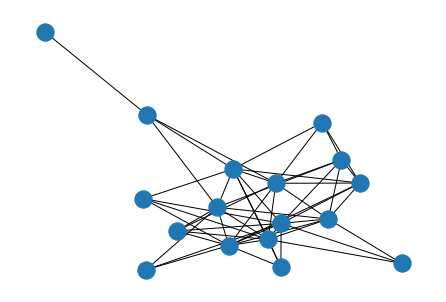

In [48]:
G_contact = nx.from_numpy_array(contact)
G_social = nx.from_numpy_array(social)

nx.draw_spring(G_contact)

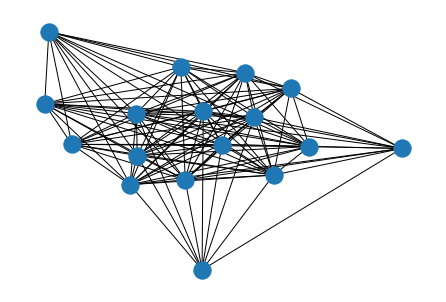

In [49]:
nx.draw_spring(G_social)

In [50]:
import networkx as nx
from node2vec import Node2Vec

# Create a graph
graph = G_contact

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=graph.number_of_nodes(), min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
print(model.wv.most_similar('2'))
print(model.wv.similarity('2', '4')) # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format('EMBEDDING')

# Save model for later use
model.save('EMBEDDING_MODEL')

# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

print(edges_embs)

# Look for embeddings on the fly - here we pass normal tuples
print('1-2',edges_embs[('1', '2')])
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
edges_kv.save_word2vec_format('EDGES_EMBEDDING')

Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 608.43it/s]


[('13', 0.9079180359840393), ('11', 0.9017595648765564), ('0', 0.867409884929657), ('1', 0.8380473256111145), ('14', 0.8365480303764343), ('3', 0.8001604080200195), ('16', 0.7835664749145508), ('12', 0.7362748384475708), ('7', 0.6984560489654541), ('9', 0.6922410726547241)]
0.6673305
1-2 [ 6.16819598e-05  4.85849305e-04  5.49575277e-02  1.11814467e-02
  7.72610819e-03  2.84911245e-02 -6.15341065e-04  1.87241007e-03
  1.86601616e-02  1.67028736e-02  7.48896971e-02  3.32471624e-04
  1.89976534e-03  2.43805363e-04  1.26158008e-02  2.43043657e-02
  3.90030700e-03  9.43183841e-05  5.97729906e-03 -3.47716804e-03
  2.40654033e-02  3.64471599e-03  5.16023710e-02  1.34457403e-03
  7.06660387e-04  1.85564682e-02  3.43204960e-02  2.62157782e-03
  9.44061298e-03  1.16865700e-02  5.47706336e-03 -8.29769671e-03
  4.68958449e-03  3.25155677e-03  1.02571109e-02  1.52330816e-04
  3.51662491e-03 -2.29677511e-03  5.38387485e-02  1.71107631e-02
  1.22943027e-02  1.15100492e-03  5.56759245e-04  5.57755353e

Generating edge features: 100%|█████████| 153/153.0 [00:00<00:00, 277684.34it/s]


In [51]:
def predictor_node2vec(Gx,i,j, **kwargs):
    # implements the node2vec link predictor
    # input : Gx:  a simple networkx graph
    #       : i,j: node indices i,j in Gx
    # output: score(i,j) given by similarity as assesed by the Node2Vec Algorithm
    #
    # Grover, Leskovek 2016, "node2vec: Scalable Feature Learning for Networks"
    # https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf
    
    dimensions = kwargs['dimensions'] 
    walk_length = kwargs['walk_length']
    num_walks = kwargs['num_walks']
    workers = kwargs['workers']
    window = kwargs['window']
    min_count = kwargs['min_count']
    batch_words = kwargs['batch_words']
    
    # Define model (note: on Windows workers=1 or error will occur)
    node2vec = Node2Vec(Gx, dimensions=dimensions, walk_length=walk_length, 
                        num_walks=num_walks, workers=workers) 

    # Fit model
    model = node2vec.fit(window=window, min_count=min_count, batch_words=batch_words)  
    
    return model.wv.similarity(str(i), str(j))


In [52]:
def predictor_Baseline():
    # implements the baseline link predictor
    # input : none, because its output is independent of G
    # output: score(i,j) = r where r = Uniform(0,1)
    
    ####################################
    ##### do not modify above here #####

    return random.uniform(0,1) # totally random

def predictor_DegreeProd(Gx,i,j):
    # implements the baseline link predictor
    # input : Gx:  a simple networkx graph
    #       : i,j: node indices i,j in Gx
    # output: score(i,j) = DegreeProduct(i,j) + Uniform(0,epsilon) for epsilon << 1 (a very small value)

    ####################################
    ##### do not modify above here #####
    
    return (Gx.degree[i]*Gx.degree[j] + random.uniform(0,0.01)) # compute degree product and add randomness


def predictor_Jaccard(Gx,i,j):
    # implements the Jaccard coefficient link predictor
    # input : Gx:  a simple networkx graph
    #       : i,j: node indices i,j in Gx
    # output: score(i,j) = Jaccard(i,j) + Uniform(0,epsilon) for epsilon << 1 (a very small value)

    ####################################
    ##### do not modify above here #####
    n = Gx.number_of_nodes()
    # get the neighbors of the nodes
    i_neighbors = set(Gx.neighbors(i))
    j_neighbors = set(Gx.neighbors(j))
    
    
    # get the intersection and union
    intersect = i_neighbors.intersection(j_neighbors)
    union = i_neighbors.union(j_neighbors)
    if not bool(union): #if union empty
        return (0 + random.uniform(0,1/(2*n))) # random
    
    else:
        return (len(intersect)/len(union) + random.uniform(0,1/(2*n))) # compute Jaccard and add the random

def apply_Predictors(G,Y):
    # input : G, a networkx simple graph
    #         Y, list of missing links in G
    # output: S, table of the form [ i | j | tau | baseline | jaccard | degree product ]

    ####################################
    ##### do not modify above here #####
    
    # Find all possible links not in G  (not the most efficient but mathematically elegant)
    Kn = nx.complete_graph(len(G.nodes())+1)  # Take complete graph (VxV = all possible edges)
    X = nx.Graph() # graph that will be filled with VxV - E
    for e in Kn.edges():
        if e[0] == 0: # want to ignore node denoted "0" which is included in complete graph
            continue
        if e not in G.edges(): # VxV - E
            X.add_edge(e[0],e[1])
    

    table = np.zeros((len(X.edges()), 7)) #rows, columns

    
    counter = 0 
    for l in X.edges():
        # get the indicies
        i = l[0]
        j = l[1]
        
        # calculate tau (are they connected?)
        if l in Y:
            tau = 1
        else:
            tau = 0
        
        # predictor calls
        baseline = predictor_Baseline()
        jaccard = predictor_Jaccard(G,i,j)
        degprod = predictor_DegreeProd(G,i,j)
        node2vec = predictor_node2vec(G,i,j,
                        window=graph.number_of_nodes(), dimensions=64, walk_length=30, 
                        num_walks=200, workers=4, min_count=1, batch_words=4)
        
        # fill the row
        table[counter,0] = i
        table[counter,1] = j
        table[counter,2] = tau
        table[counter,3] = baseline
        table[counter,4] = jaccard
        table[counter,5] = degprod
        table[counter,6] = node2vec
        
        counter += 1 # indexing
    
    return table
        

def tabulate_TPR_FPR(S):
    # see Lecture Notes 4
    # input : a data structure S containing a table whose rows have the form:
    #         [ i j tau score(i,j) ]
    #        sorted in descending order of score(i,j)
    # output: a data structure T containing a table whose rows have the form:
    #         [ i j tau TPR FPR score(i,j) ]
    #        sorted descending in score(i,j)

    ####################################
    ##### do not modify above here #####

    nrow = S.shape[0] # get number of rows
    out = np.zeros((nrow + 1,6)) # define out array
    
    n_True = np.sum(S[:,2]) # sum of tau
    n_False = nrow - n_True # nrow - tau
    
    # counters
    tp_count = 0
    fp_count = 0
    
    counter = 1 # leave a row of all zeros at the beginning.
    for row in S:
        if row[2]:
            tp_count += 1 # if a true positive
        else:
            fp_count += 1
            
        # copy metadata
        out[counter,0] = row[0]
        out[counter,1] = row[1]
        out[counter,2] = row[2]
        
        # if at least one true edge
        if n_True:
            out[counter,3] = tp_count/n_True # TPR
        else:
            out[counter,3] = 0
            
        out[counter,4] = fp_count/n_False # FPR
        out[counter,5] = row[3] # copy score
        
        counter += 1
        
    return out
        
    
def calculate_AUC(TPR,FPR):
    # see Lecture Notes 4
    # input : the TPR and FPR columns of your table (which have equal length and where TPR[0]=FPR[0]=0)
    # output: the AUC, a scalar on the unit interval

    ####################################
    ##### do not modify above here #####

    nrow = len(TPR) # number of rows
    stepsize = 1/nrow
    
    a_rectangle = []
    for n in range(nrow):
        a_rectangle.append(TPR[n]*stepsize) # area of rectangle
    
    return np.sum(a_rectangle)

Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 2340.18it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 2252.46it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 2334.06it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 2324.18it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 2368.54it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 2323.64it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 2335.46it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 2328.07it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 2328.31it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 2378.45it/s]


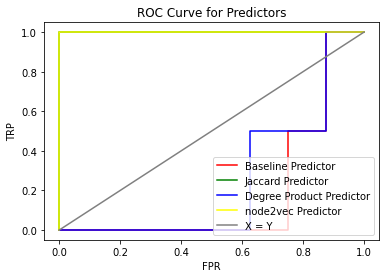

Baseline AUC: 0.2727272727272727
Jaccard AUC: 0.8636363636363638
Degree Product AUC: 0.3181818181818182
node2vec AUC: 0.8636363636363638


In [53]:
Go      = nx.Graph([(1,2),(1,3),(3,4),(5,6),(4,6)]) # observed graph Go, from Lecture 4
missing = [(2,3),(4,5)]                             # list of edges missing from Go

table = apply_Predictors(Go,missing) # apply predictors

# sort by score
uniform = table[np.flipud(table[:, -4].argsort())]
jaccard = table[np.flipud(table[:, -3].argsort())]
degprod = table[np.flipud(table[:, -2].argsort())]
node2vec = table[np.flipud(table[:, -1].argsort())]

# subset for TPR_FPR
uniform = uniform[:,[0,1,2,3]]
jaccard = jaccard[:,[0,1,2,4]]
degprod = degprod[:,[0,1,2,5]]
node2vec = node2vec[:,[0,1,2,6]]

# get reciever
u_reciever = tabulate_TPR_FPR(uniform)
j_reciever = tabulate_TPR_FPR(jaccard)
d_reciever = tabulate_TPR_FPR(degprod)
n_reciever = tabulate_TPR_FPR(node2vec)

#y=x curve
xy = np.linspace(0,1,50)

# plot recievers (extra credit)
fig = plt.figure()
ax = fig.subplots()
ax.plot(u_reciever[:,4], u_reciever[:,3], label = "Baseline Predictor", color = "red")
ax.plot(j_reciever[:,4], j_reciever[:,3], label = "Jaccard Predictor", color = "green")
ax.plot(d_reciever[:,4], d_reciever[:,3], label = "Degree Product Predictor", color = "blue")
ax.plot(n_reciever[:,4], n_reciever[:,3], label = "node2vec Predictor", color = "yellow")
ax.plot(xy,xy, label = "X = Y", color = "grey")
ax.legend(loc = 'lower right')
plt.xlabel("FPR")
plt.ylabel("TRP")
plt.title("ROC Curve for Predictors")
plt.show()

# calculate AUC
u_auc = calculate_AUC(u_reciever[:,3], u_reciever[:,4])
j_auc = calculate_AUC(j_reciever[:,3], j_reciever[:,4])
d_auc = calculate_AUC(d_reciever[:,3], d_reciever[:,4])
n_auc = calculate_AUC(n_reciever[:,3], n_reciever[:,4])


print("Baseline AUC:", u_auc)
print("Jaccard AUC:", j_auc)
print("Degree Product AUC:", d_auc)
print("node2vec AUC:", n_auc)